#  Autoencoder


In [3]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [4]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


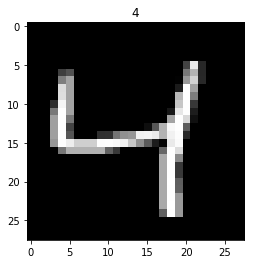

In [5]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [6]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

AutoEncoder (
  (encoder): Sequential (
    (0): Linear (784 -> 128)
    (1): Tanh ()
    (2): Linear (128 -> 64)
    (3): Tanh ()
    (4): Linear (64 -> 12)
    (5): Tanh ()
    (6): Linear (12 -> 3)
  )
  (decoder): Sequential (
    (0): Linear (3 -> 12)
    (1): Tanh ()
    (2): Linear (12 -> 64)
    (3): Tanh ()
    (4): Linear (64 -> 128)
    (5): Tanh ()
    (6): Linear (128 -> 784)
    (7): Sigmoid ()
  )
)
Epoch:  0 | train loss: 0.2323


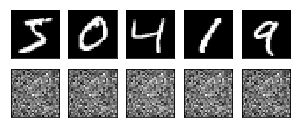

Epoch:  0 | train loss: 0.0559


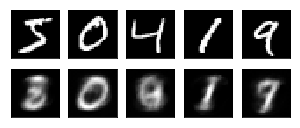

Epoch:  5 | train loss: 0.0374


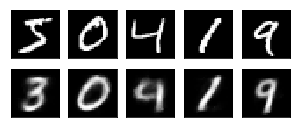

Epoch:  5 | train loss: 0.0349


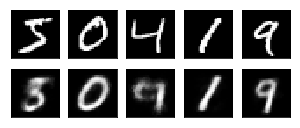

Epoch:  9 | train loss: 0.0367


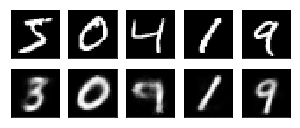

Epoch:  9 | train loss: 0.0351


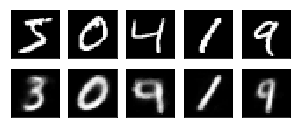

In [9]:
autoencoder = AutoEncoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)
            

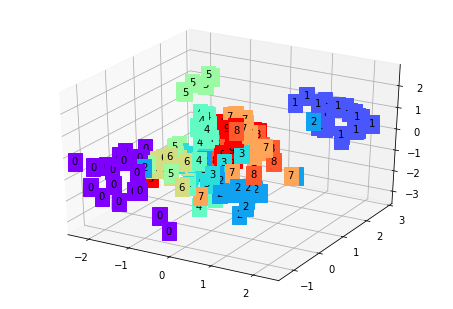

In [11]:
# visualize in 3D plot
view_data = Variable(train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.)
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()